In [7]:
from pyspark.sql import SparkSession
import os
import tempfile
import urllib.request

# Create Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("K_means") \
    .getOrCreate()

# Correct raw GitHub URL and safe local path (no leading slash in filename)
url = "https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_7_Clustering/iris_dataset.csv"
local_path = os.path.join(tempfile.gettempdir(), "iris_dataset.csv")

# Download dataset (overwrites if already present)
urllib.request.urlretrieve(url, local_path)

# Read with Spark
df = spark.read.csv(local_path, header=True, inferSchema=True)

# Quick sanity check
print(f"Loaded file: {local_path} (exists={os.path.exists(local_path)})")
df.show(5)

Loaded file: /tmp/iris_dataset.csv (exists=True)
+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows


In [3]:
df.count(), df.columns

(150,
 ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

In [4]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [9]:
from pyspark.sql.functions import rand

df.orderBy(rand(seed=42)).show(10, False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|7.6         |3.0        |6.6         |2.1        |virginica |
|5.4         |3.9        |1.3         |0.4        |setosa    |
|7.2         |3.6        |6.1         |2.5        |virginica |
|7.7         |2.8        |6.7         |2.0        |virginica |
|5.5         |2.6        |4.4         |1.2        |versicolor|
|6.4         |2.8        |5.6         |2.1        |virginica |
|5.7         |2.6        |3.5         |1.0        |versicolor|
|6.9         |3.1        |5.1         |2.3        |virginica |
|6.6         |2.9        |4.6         |1.3        |versicolor|
|5.6         |3.0        |4.1         |1.3        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows


In [10]:
df.groupBy('species').count().orderBy('count', ascending=False).show()

+----------+-----+
|   species|count|
+----------+-----+
| virginica|   50|
|versicolor|   50|
|    setosa|   50|
+----------+-----+



In [11]:
# Feature engineering

In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

input_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

vec_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

final_data = vec_assembler.transform(df)

final_data.show(5, False)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|features         |
+------------+-----------+------------+-----------+-------+-----------------+
|5.1         |3.5        |1.4         |0.2        |setosa |[5.1,3.5,1.4,0.2]|
|4.9         |3.0        |1.4         |0.2        |setosa |[4.9,3.0,1.4,0.2]|
|4.7         |3.2        |1.3         |0.2        |setosa |[4.7,3.2,1.3,0.2]|
|4.6         |3.1        |1.5         |0.2        |setosa |[4.6,3.1,1.5,0.2]|
|5.0         |3.6        |1.4         |0.2        |setosa |[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 5 rows


In [13]:
# Build KMeans model

In [17]:
from pyspark.ml.clustering import KMeans

errors = []

for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(final_data)
    wssse = model.summary.trainingCost
    errors.append(wssse)

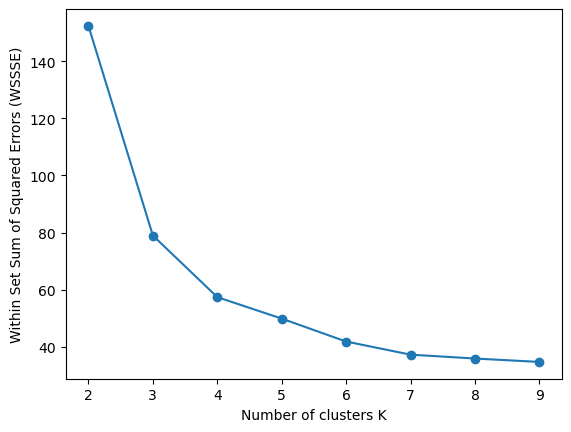

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cluster_numbers = list(range(2, 10))

plt.xlabel('Number of clusters K')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.plot(cluster_numbers, errors, marker='o')
plt.xticks(cluster_numbers)
plt.show()

In [24]:
kmeans = KMeans(featuresCol='features', k=3, seed=42)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('species', 'prediction').count().orderBy('species', 'prediction').show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
|    setosa|         0|   50|
|versicolor|         1|    3|
|versicolor|         2|   47|
| virginica|         1|   36|
| virginica|         2|   14|
+----------+----------+-----+



In [25]:
predict_df = model.transform(final_data)
predict_df = predict_df.toPandas()

predict_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",0
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",0
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",0
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",0
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",0


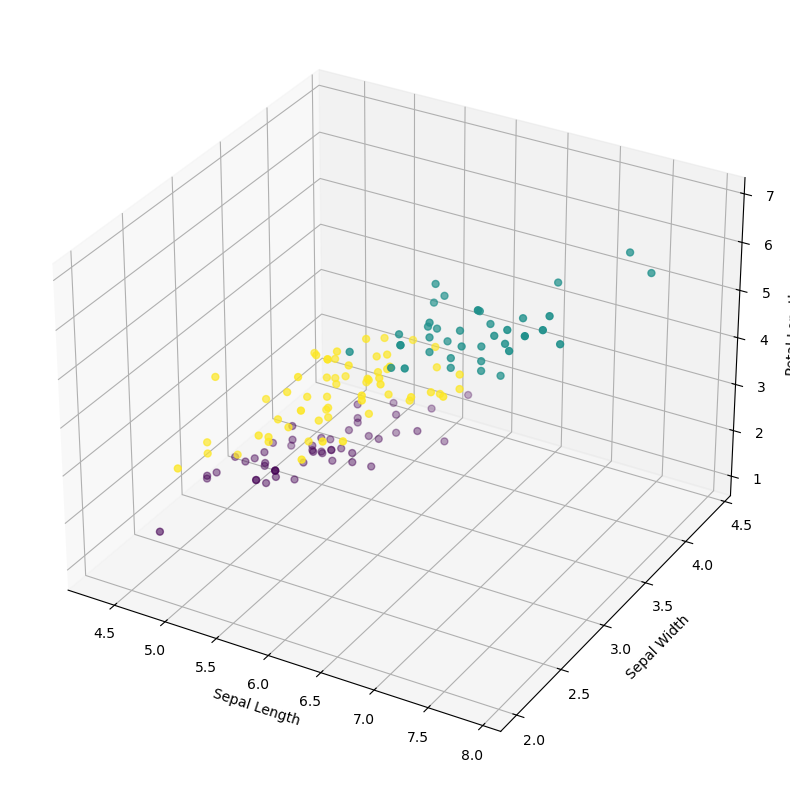

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
cluster_vis = fig.add_subplot(111, projection='3d')
cluster_vis.scatter(predict_df['sepal_length'], predict_df['sepal_width'], predict_df['petal_length'],
                    c=predict_df['prediction'], s=25)
cluster_vis.set_xlabel('Sepal Length')
cluster_vis.set_ylabel('Sepal Width')
cluster_vis.set_zlabel('Petal Length')
plt.show()